In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch as t
from utils.config import opt
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
%matplotlib inline

In [2]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

# Load model trained with caffe pretrained model

In [3]:
trainer.load('./checkpoints/fasterrcnn_02071907_0.7010876357676961')
opt.caffe_pretrain=True # this model was trained from caffe-pretrained model

In [4]:
img = read_image('misc/demo.jpg')
img = t.from_numpy(img)[None]

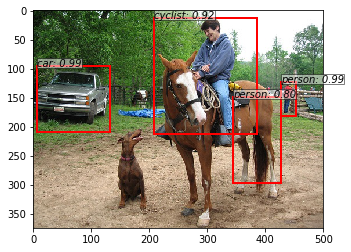

In [5]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

# Display a Kitti image

In [6]:
img = read_image('/media/tadenoud/DATADisk/datasets/kitti_2d/testing/image_2/005009.png')
img = t.from_numpy(img)[None]

FileNotFoundError: [Errno 2] No such file or directory: '/media/tadenoud/DATADisk/datasets/kitti_2d/testing/image_2/005009.png'

In [ ]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

In [ ]:
print(trainer.faster_rcnn)

In [22]:
list(list(trainer.faster_rcnn.head.children())[0].children())[:]

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace)]